# House Price Prediction: Machine Learning Pipeline
### Name: Ali Mir
___

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

from scipy.stats import spearmanr

import shap
shap.initjs()

## Load and Inspect the df

In [2]:
df = pd.read_csv('dataset.csv', low_memory=False)
print(df.head(3))
print("\n\n")
print(df.info())


   LotArea  GrLivArea Street Alley  LotType BldgType HouseStyle  \
0     8910       1194   Pave   NaN   Corner     1Fam       1Fam   
1     1526        630   Pave   NaN   Inside    Twnhs     SFoyer   
2    14598       1933   Pave   NaN  CulDSac     1Fam     2Story   

   OverallQuality  OverallCondition  YearBuilt  ... CentralAir  FullBath  \
0               6                 6       1959  ...          Y         1   
1               4                 8       1970  ...          Y         1   
2               6                 5       2007  ...          Y         2   

  HalfBath  GarageType  GarageCars GarageArea  YearSold  SaleType  \
0        0     BuiltIn           2      539.0      2006        WD   
1        0      Attchd           1      286.0      2009        WD   
2        1     BuiltIn           3      668.0      2008        WD   

   SaleCondition SalePrice  
0         Normal    159500  
1         Normal     86000  
2         Normal    214000  

[3 rows x 22 columns]



<class 

### DF Summary

- 1460 entries
- Total 22 columns

| #   | Column           | Null Count | Data Type | #   | Column           | Null Count | Data Type |
|-----|------------------|------------|-----------|-----|------------------|------------|-----------|
| 0   | LotArea          | 0          | int       | 11  | TotalBsmtSF      | 0          | int       |
| 1   | GrLivArea        | 0          | int       | 12  | CentralAir       | 0          | object    |
| 2   | Street           | 0          | object    | 13  | FullBath         | 0          | int       |
| 3   | Alley            | 91         | object    | 14  | HalfBath         | 0          | int       |
| 4   | LotType          | 0          | object    | 15  | GarageType       | 1379       | object    |
| 5   | BldgType         | 0          | object    | 16  | GarageCars       | 0          | int       |
| 6   | HouseStyle       | 0          | object    | 17  | GarageArea       | 1417       | float     |
| 7   | OverallQuality   | 0          | int       | 18  | YearSold         | 0          | int       |
| 8   | OverallCondition | 0          | int       | 19  | SaleType         | 0          | object    |
| 9   | YearBuilt        | 0          | int       | 20  | SaleCondition    | 0          | object    |
| 10  | Foundation       | 0          | object    | 21  | SalePrice        | 0          | int       |


## DF Cleaning

**Observations**:

- `Alley`: Only 91 non-null → Drop

- `GarageType`: 1379 non-null → Minor missing, impute with `np.nan` type

- `GarageArea`: 1417 non-null → Minor missing, impute with `np.nan` type

- We treat rows where `Foundation` = '**Do Not use this Field in the Model**' as missing values (`np.nan`)

- All others: Complete

In [3]:
# Drop 'Alley' due to excessive missing values
df = df.drop(columns=['Alley'])

# Impute missing values
df['GarageType'] = df['GarageType'].fillna('NA').replace('NA', np.nan)
df['GarageArea'] = df['GarageArea'].fillna('NA').replace('NA', np.nan)

# Treat specific invalid value in 'Foundation' column as missing
df['Foundation'] = df['Foundation'].replace("Do Not use this Field in the Model", np.nan)

# Confirm cleanup
print(df.isnull().sum())


LotArea              0
GrLivArea            0
Street               0
LotType              0
BldgType             0
HouseStyle           0
OverallQuality       0
OverallCondition     0
YearBuilt            0
Foundation          84
TotalBsmtSF          0
CentralAir           0
FullBath             0
HalfBath             0
GarageType          81
GarageCars           0
GarageArea          43
YearSold             0
SaleType             0
SaleCondition        0
SalePrice            0
dtype: int64


### Handling Missing Values in `GarageArea` Using `GarageCars`

We observed a strong linear relationship between the number of garage cars (`GarageCars`) and the size of the garage (`GarageArea`):

In [4]:
correlation = df['GarageCars'].corr(df['GarageArea'])
print(f"Correlation between Garage Cars and Garage Area: {correlation:.3f}\n")

# To confirm this relationship with all features:
correlations = df.corr(numeric_only=True)['GarageCars'].sort_values(ascending=False)
print(correlations)

Correlation between Garage Cars and Garage Area: 0.882

GarageCars          1.000000
GarageArea          0.881677
SalePrice           0.640409
OverallQuality      0.600671
YearBuilt           0.537850
FullBath            0.469672
TotalBsmtSF         0.434585
HalfBath            0.219178
GrLivArea           0.208062
LotArea             0.154871
YearSold           -0.039117
OverallCondition   -0.185758
Name: GarageCars, dtype: float64


Strategy for Imputation:

- Set `GarageArea` to 0 where `GarageCars` is 0 (This is based on the assumption that if there are no cars, there is no garage area)
- Use a **Linear Regression** model to predict missing `GarageArea` values for rows where `GarageCars` > 0
- May (later) drop `GarageCars` after imputation to reduce multicollinearity

In [5]:
# Step 1: If GarageCars == 0, then GarageArea = 0
df.loc[df['GarageCars'] == 0, 'GarageArea'] = 0

# Step 2: Predict missing GarageArea using GarageCars
# Identify rows where GarageArea is not null and GarageCars > 0
train_mask = df['GarageArea'].notnull() & (df['GarageCars'] > 0)
test_mask = df['GarageArea'].isnull() & (df['GarageCars'] > 0)

# Prepare df
X_train = df.loc[train_mask, ['GarageCars']]
y_train = df.loc[train_mask, 'GarageArea']
X_test = df.loc[test_mask, ['GarageCars']]

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and fill missing values
predicted = model.predict(X_test)
df.loc[test_mask, 'GarageArea'] = predicted

## Step 3: Drop GarageCars column
# df.drop(columns='GarageCars', inplace=True)

In [6]:
# GarageArea prediction example
df[["GarageCars", "GarageArea"]].iloc[[38, 39], :]

,GarageCars,GarageArea
38,2,472.000000
39,2,532.210646


## DF Descriptive Statistics

### Numerical Columns

In [7]:
# df.describe().applymap(lambda x: f"{x:.2f}")

# Basic summary stats
desc = df.describe().T

# Add skewness column
desc['skew'] = df.skew(numeric_only=True)

# Round everything nicely
desc = desc.round(2)

# Display
desc


,count,mean,std,min,25%,50%,75%,max,skew
LotArea,1460.0,10516.83,9981.26,1300.0,7553.50,9478.5,11601.50,215245.0,12.21
GrLivArea,1460.0,1567.21,1072.20,334.0,1130.75,1466.0,1784.50,23400.0,12.86
OverallQuality,1460.0,6.10,1.38,1.0,5.00,6.0,7.00,10.0,0.22
OverallCondition,1460.0,5.58,1.11,1.0,5.00,5.0,6.00,9.0,0.69
YearBuilt,1460.0,1971.27,30.20,1872.0,1954.00,1973.0,2000.00,2010.0,-0.61
TotalBsmtSF,1460.0,1057.43,438.71,0.0,795.75,991.5,1298.25,6110.0,1.52
FullBath,1460.0,1.57,0.55,0.0,1.00,2.0,2.00,3.0,0.04
HalfBath,1460.0,0.38,0.50,0.0,0.00,0.0,1.00,2.0,0.68
GarageCars,1460.0,1.77,0.75,0.0,1.00,2.0,2.00,4.0,-0.34
GarageArea,1460.0,472.86,213.13,0.0,326.00,480.0,576.00,1418.0,0.17


### Cardinality Check (for Categorical Columns or ones with Multi Groups)

In [8]:
df[['Street', 'LotType', 'BldgType', 'HouseStyle', 'OverallQuality', 'OverallCondition',\
   'Foundation', 'CentralAir', 'FullBath', 'HalfBath', 'GarageType', 'GarageCars',\
    'SaleType', 'SaleCondition']].nunique()

Street               2
LotType              5
BldgType             5
HouseStyle           9
OverallQuality      10
OverallCondition     9
Foundation           6
CentralAir           2
FullBath             4
HalfBath             3
GarageType           6
GarageCars           5
SaleType             9
SaleCondition        7
dtype: int64

## Target Variable (SalePrice) Distribution

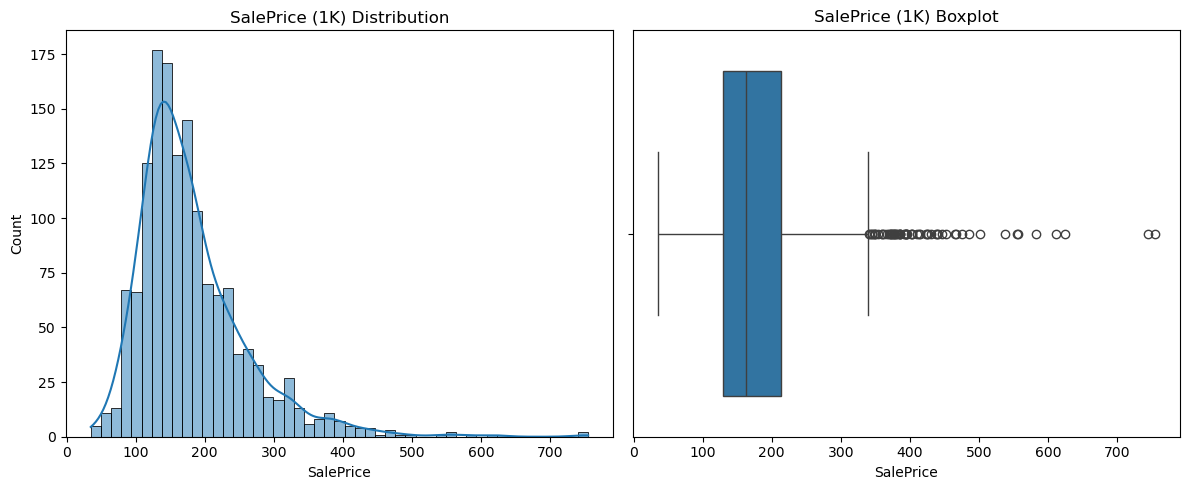

In [9]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with KDE
sns.histplot(df['SalePrice']/1000, kde=True, ax=axes[0])
axes[0].set_title('SalePrice (1K) Distribution')

# Boxplot
sns.boxplot(x=df['SalePrice']/1000, ax=axes[1])
axes[1].set_title('SalePrice (1K) Boxplot')

plt.tight_layout()
plt.show()

## Time-based Trend for SalePrice

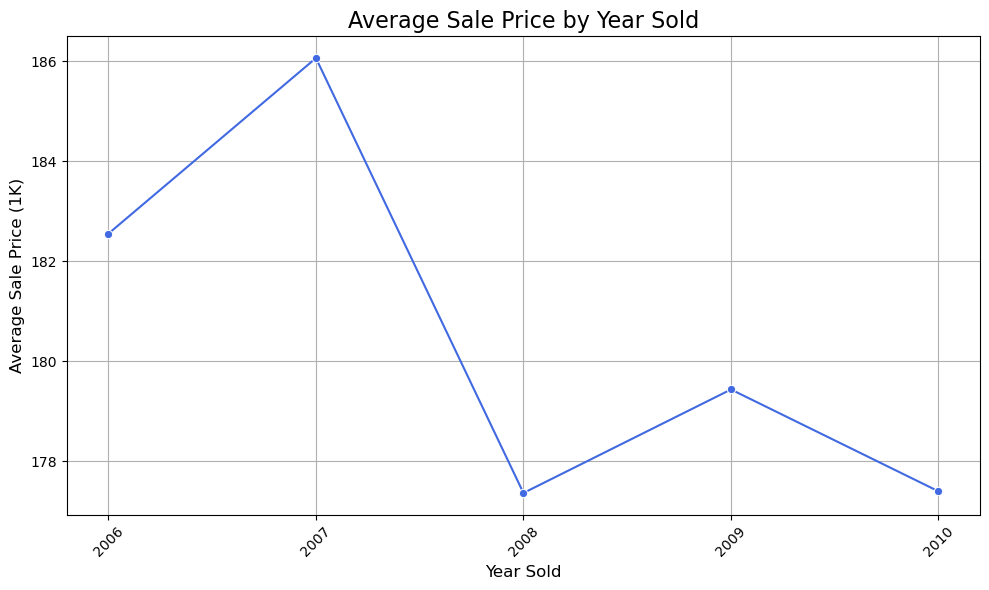

In [10]:
# df.groupby('YearSold')['SalePrice'].mean().plot()

# Compute average sale price per year
avg_price_by_year = df.groupby('YearSold')['SalePrice'].mean()/1000

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_price_by_year.index, y=avg_price_by_year.values, marker='o', color='royalblue')

# Customize it
plt.title('Average Sale Price by Year Sold', fontsize=16)
plt.xlabel('Year Sold', fontsize=12); plt.ylabel('Average Sale Price (1K)', fontsize=12)
plt.xticks(avg_price_by_year.index, rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


## Feature Encoding

- Encode categorical features
- Create new feature: age of house at sale time
- Use **Label Encoding** for binary features like `CentralAir`, and **One-Hot Encoding** for multi-category fields like `BldgType`, `HouseStyle`, etc.

In [11]:
# Create new feature: age of house at sale time
df['HouseAge'] = df['YearSold'] - df['YearBuilt']

# Convert 'CentralAir' to binary (Label encode binary column)
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})

# One-hot encode categorical variables
categoricals = ['Street', 'LotType', 'BldgType', 'HouseStyle', 
                'Foundation', 'GarageType', 'SaleType', 'SaleCondition']
df = pd.get_dummies(df, columns=categoricals, drop_first=True)


In [12]:
df.head(5)

,LotArea,GrLivArea,OverallQuality,OverallCondition,YearBuilt,TotalBsmtSF,CentralAir,FullBath,HalfBath,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_normal
0,8910,1194,6,6,1959,655,1,1,0,2,...,0,0,0,1,0,0,0,1,0,0
1,1526,630,4,8,1970,630,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0
2,14598,1933,6,5,2007,894,1,2,1,3,...,0,0,0,1,0,0,0,1,0,0
3,7200,1040,4,5,1949,0,0,2,0,2,...,0,0,0,1,0,0,0,1,0,0
4,5687,1716,5,6,1912,780,0,2,0,0,...,0,0,0,1,0,0,0,1,0,0


## Spearman's Correlation Analysis

This computes the pairwise Spearman rank correlation coefficients between all features in the dataset, along with their 95% confidence intervals using Fisher’s z-transformation. It highlights strongly correlated feature pairs (|ρ| > 0.90), helping to identify potential multicollinearity or redundant features. Duplicate pairings are filtered to avoid repetition in results.

We used Spearman's technique instead of the more common Pearson correlation for the following reasons:
- Non-Linearity Tolerance, Robust to Outliers, No Assumptions of Normality or Equal Variance

In [13]:
# function to compute Spearman correlation coefficient and its 95% CI
def compute_spearman_correlation_with_ci(x, y):
    rho, p = spearmanr(x, y)
    r_z = np.arctanh(rho)  # Fisher z-transform for CI calculation
    se = 1 / np.sqrt(len(x) - 3)
    z = 1.96  # For 95% CI
    ci = (np.tanh(r_z - z * se), np.tanh(r_z + z * se))
    return rho, ci

# Store high correlations
high_correlations = []
limit = 0.90

# Compute Spearman correlation coefficients and CIs for each pair of variables
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
for i, col1 in enumerate(df.columns):
    for j, col2 in enumerate(df.columns):
        if i != j:  # Avoid computing correlation of a var with itself
            rho, ci = compute_spearman_correlation_with_ci(df[col1], df[col2])
            correlation_matrix.at[col1, col2] = f"{rho:.2f} ({ci[0]:.2f}, {ci[1]:.2f})"

            if abs(rho) > limit:
                high_correlations.append((col1, col2, rho))
        else:
            correlation_matrix.at[col1, col2] = 1.0  # Set diagonal elements to 1

## Display the correlation matrix with Spearman correlation coefficients and CIs
# print("Spearman Correlation Matrix with 95% CIs:")
# correlation_matrix

seen = set()
print(f"Pairs of features with Spearman correlation coefficient > {limit}:\n")

for col1, col2, rho in high_correlations:
    # Sort the pair to avoid (A, B) and (B, A) both showing
    pair = tuple(sorted([col1, col2]))
    
    if pair not in seen:
        seen.add(pair)
        print(f"{pair[0]} and {pair[1]}: rho = {rho:.2f}")

Pairs of features with Spearman correlation coefficient > 0.9:

HouseAge and YearBuilt: rho = -1.00
SaleCondition_Partial and SaleType_New: rho = 0.99


Houses that are new (`SaleType_New` == 1) are almost always sold with the "Partial" sale condition (Home was partially completed when the sale occurred) and vice versa.

In [14]:
# Drop multi-collinear columns
df.drop(columns=['YearBuilt', 'SaleCondition_Partial'], inplace=True)

## Modeling

Regression with Repeated **Cross-Validation** and **Hyperparameter Tuning**

Description:
This code performs Ridge and XGBoost regressions to predict housing prices using a pipeline that includes feature scaling and model regularization. It uses GridSearchCV with RepeatedKFold cross-validation to identify the optimal values for the regression models by maximizing R² score. The model's performance is evaluated using cross-validation across the entire dataset.

To test generalization, we consider splitting n% of the whole data as a blind hold-out set before model training, and evaluate final performance on that unseen portion after tuning is complete.

## Ridge Regressor
This is a good linear regression choice because it adds **L2 regularization**, which:

- Reduces overfitting by shrinking large coefficients.
- Handles multicollinearity well, improving model stability.
- Balances bias and variance leading to better generalization on unseen data.

It's especially effective when we have correlated features.

In [15]:
# Split off n% of data as final blind test set and define features and target
blind = 20

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X, X_blind, y, y_blind = train_test_split(X, y, test_size=blind/100, random_state=42)
# -----------------------------------------
# Define model and hyperparameter grid
model = make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 5, 10, 30, 40, 50, 75, 100]}

# Set up repeated K-Fold cross-validator for regression
cv_repeat = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Grid search with repeated CV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv_repeat,
    scoring= 'r2',  #'neg_root_mean_squared_error'
    n_jobs=-1
)

# tune hyperparameter
grid_search.fit(X, y)
print("=> Best Parameters:", grid_search.best_params_)
print(f"=> Best Score (CV R²): {grid_search.best_score_:.5f}")

best_alpha = grid_search.best_params_['ridge__alpha']
print("=> Saved Best Alpha:", best_alpha)
# --------------------------------------------------------
# Get the best fitted model directly from GridSearchCV
final_model = grid_search.best_estimator_

# Predict on blind hold-out test set
y_blind_pred = final_model.predict(X_blind)

# Evaluate performance (example: R² score)
blind_r2 = r2_score(y_blind, y_blind_pred)
print(f"\n=> Final R² on {blind}% Blind Hold-Out Set: {blind_r2:.5f}")

=> Best Parameters: {'ridge__alpha': 30}
=> Best Score (CV R²): 0.78326
=> Saved Best Alpha: 30

=> Final R² on 20% Blind Hold-Out Set: 0.63817


## XGBoost Regressor

- Handles Non-Linearity: Captures complex relationships in data.
- Built-in Regularization: Reduces overfitting automatically.
- Efficient & Scalable: Fast training, even on large datasets.
- Feature Importance: Provides insights into feature contributions.


In [16]:
# Split off blind % of data as final blind test set
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X, X_blind, y, y_blind = train_test_split(X, y, test_size=blind/100, random_state=42)

# Define pipeline
model = make_pipeline(
    StandardScaler(),
    XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)
)

# Define hyperparameter grid
param_grid = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2]
}

# Repeated CV
cv_repeat = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Grid search with CV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv_repeat,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Train and tune
grid_search.fit(X, y)

# Best parameters and CV performance
print("\n=> Best Parameters:", grid_search.best_params_)
print(f"=> Best Score (CV R²): {grid_search.best_score_:.5f}")

# Get best fitted model directly
best_model = grid_search.best_estimator_

# Predict on the blind% hold-out blind test set
y_blind_pred = best_model.predict(X_blind)

# Evaluate performance on blind test set
blind_r2 = r2_score(y_blind, y_blind_pred)
print(f"\n=> Final R² on {blind}% Blind Hold-Out Set: {blind_r2:.5f}")


Fitting 15 folds for each of 18 candidates, totalling 270 fits

=> Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 100}
=> Best Score (CV R²): 0.83761

=> Final R² on 20% Blind Hold-Out Set: 0.86770


### XGBoost Regressor: Different Performance Metrics Evaluation (on blind test set)

In [17]:
blind_r2 = r2_score(y_blind, y_blind_pred)
blind_mae = mean_absolute_error(y_blind, y_blind_pred)
blind_mse = mean_squared_error(y_blind, y_blind_pred)
blind_rmse = np.sqrt(blind_mse)
blind_mape = mean_absolute_percentage_error(y_blind, y_blind_pred)
blind_explained_variance = explained_variance_score(y_blind, y_blind_pred)

# Print out all metrics
print(f"=> Final R² on {blind}% Blind Hold-Out Set: {blind_r2:.5f}")
print(f"=> Final MAE on {blind}% Blind Hold-Out Set: {blind_mae:.5f}")
print(f"=> Final MSE on {blind}% Blind Hold-Out Set: {blind_mse:.5f}")
print(f"=> Final RMSE on {blind}% Blind Hold-Out Set: {blind_rmse:.5f}")
print(f"=> Final MAPE on {blind}% Blind Hold-Out Set: {blind_mape:.5f}")
print(f"=> Final Explained Variance on {blind}% Blind Hold-Out Set: {blind_explained_variance:.5f}")

=> Final R² on 20% Blind Hold-Out Set: 0.86770
=> Final MAE on 20% Blind Hold-Out Set: 18971.62885
=> Final MSE on 20% Blind Hold-Out Set: 824765620.27388
=> Final RMSE on 20% Blind Hold-Out Set: 28718.73292
=> Final MAPE on 20% Blind Hold-Out Set: 0.10412
=> Final Explained Variance on 20% Blind Hold-Out Set: 0.86849


### See R² Performance During CV Folds (on training data)

In [18]:
# Get R² scores across all CV folds
cv_scores = cross_val_score(best_model, X, y, cv=cv_repeat, scoring='r2', n_jobs=-1)

# Convert to DataFrame to use .describe()
cv_scores_df = pd.DataFrame(cv_scores, columns=['R2 Score'])

# Show descriptive statistics
cv_scores_df.describe()

,R2 Score
count,15.000000
mean,0.837614
std,0.048491
min,0.720172
25%,0.826625
50%,0.845127
75%,0.867261
max,0.891295


The XGBoost Regressor's cross-validation across 15 folds shows strong and consistent performance:

- Mean R² Score: 0.8376 (explains ~83.8% variance)
- Standard Deviation: 0.0485 (stable performance)
- Minimum R²: 0.7202 (strong lower bound)
- 75th Percentile: 0.8673 (25% of folds above 86.7%)
- Median: 0.8451 (strong central tendency)
- Maximum R²: 0.8913 (peak performance)

Overall, the model is accurate, robust, and stable across data splits, ensuring reliable generalization.

## SHAP (SHapley Additive exPlanations) Feature Importance for XGBoost Model

- XGBoost Feature Importance is good for a quick overview of which features matter most in the model.
- SHAP is preferred for a deeper understanding of feature impact and how they contribute to each prediction, especially in complex or black-box models like XGBoost.

- SHAP explains how much each feature contributes to each prediction, based on game theory.
- It assigns a SHAP value to each feature, indicating its impact (positive or negative) on the predicted outcome.

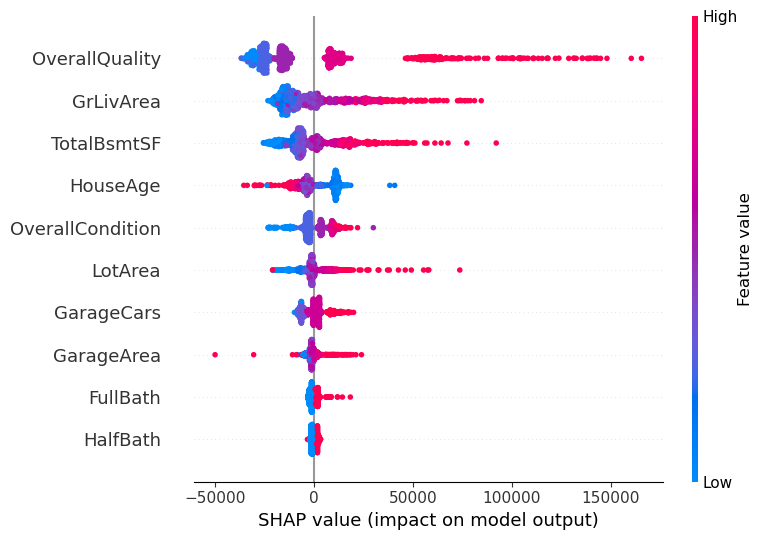

In [19]:
# Create an explainer
explainer = shap.TreeExplainer(best_model.named_steps['xgbregressor'])

# Scale the features before plotting SHAP values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create SHAP values using the scaled features
shap_values_scaled = explainer.shap_values(X_scaled)

# summary plot for the scaled features (top 10 most impactful)
shap.summary_plot(shap_values_scaled, X, max_display=10)


In [20]:
## Bar plot to show mean absolute SHAP value for each feature
# shap.summary_plot(shap_values_scaled, X, plot_type="bar", max_display=10)